In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install datasets gradio evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB

In [2]:
import pandas as pd
import re
import torch
import os
from bs4 import BeautifulSoup
from transformers import ElectraTokenizer, ElectraForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader
import datasets
from datasets import Dataset, DatasetDict
from tqdm import tqdm

In [3]:
# Load ELECTRA tokenizer and model
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Load data
df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
df_valid = pd.read_csv('/content/drive/MyDrive/valid.csv')

# Preprocess data
df_train = df_train.filter(['Title', 'Body', 'Tags', 'Y'])
df_train['Y'] = df_train['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})

df_valid = df_valid.filter(['Title', 'Body', 'Tags', 'Y'])
df_valid['Y'] = df_valid['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})

In [5]:
class Preprocessing:
    def __get_body_tag_text(self, text):
        soup = BeautifulSoup(text, features='xml')
        return soup.get_text()

    def __lower_and_punc_removal(self, text):
        text = text.lower()
        text = re.sub(r'[^(a-zA-Z)\s]', '', text)
        return text

    def __init__(self, df):
        self.df = df
        self.df['Body_Between_Tags'] = self.df['Body'].apply(self.__get_body_tag_text)
        self.df['Final_clean'] = self.df['Body_Between_Tags'].apply(self.__lower_and_punc_removal)

PreprocessedObject_train = Preprocessing(df=df_train)
PreprocessedObject_valid = Preprocessing(df=df_valid)

PreprocessedObject_train.df.dropna(inplace=True)
PreprocessedObject_valid.df.dropna(inplace=True)
PreprocessedObject_train.df.reset_index(inplace=True)
PreprocessedObject_valid.df.reset_index(inplace=True)

df_train_final = PreprocessedObject_train.df
df_valid_final = PreprocessedObject_valid.df

df_train_final.drop(['index', 'Tags', 'Body', 'Title'], inplace=True, axis=1)
df_valid_final.drop(['index', 'Tags', 'Body', 'Title'], inplace=True, axis=1)


# Retain the label column
df_train_final = df_train_final[['Final_clean', 'Y']]
df_valid_final = df_valid_final[['Final_clean', 'Y']]


<ipython-input-5-de1d49fcc152>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, features='xml')
<ipython-input-5-de1d49fcc152>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, features='xml')


In [6]:
# Create DatasetDict
datasets_train_test = DatasetDict({
    "train": Dataset.from_pandas(df_train_final),
    "test": Dataset.from_pandas(df_valid_final)
})

In [7]:
# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["Final_clean"], padding="max_length", truncation=True)

tokenized_datasets = datasets_train_test.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['Final_clean'])
tokenized_datasets = tokenized_datasets.rename_column("Y", "labels")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/45000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [8]:
# Create dataloaders
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=8)
eval_dataloader = DataLoader(tokenized_datasets["test"], batch_size=8)

In [9]:
# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
print(df_train_final.head())
print(df_valid_final.head())

                                         Final_clean  Y
0  im already familiar with repeating tasks every...  0
1  id like to understand why java  optionals were...  2
2  i am attempting to overlay a title over an ima...  2
3  the question is very simple but i just could n...  2
4  im using custom floatingactionmenu i need to i...  2
                                         Final_clean  Y
0                                                     1
1                                                     1
2  im trying to extract us states from wiki url a...  2
3                                                     1
4                                                     1


In [ ]:
print(tokenized_datasets)
print(tokenized_datasets['test'])  # Use the correct key 'test' to access the test dataset


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 45000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15000
    })
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 15000
})


In [10]:
# Move model to appropriate device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

progress_bar = tqdm(range(num_training_steps))
model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        if batch is not None and isinstance(batch, dict) and all(v is not None for v in batch.values()):  # Check if batch is not None and contains valid data
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
        else:
            print("Warning: Empty or invalid batch encountered.")

100%|██████████| 5625/5625 [1:09:26<00:00,  1.35it/s]

In [ ]:
correct = 0
total = 0
model.eval()

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    correct += torch.sum(predictions == batch["labels"]).item()
    total += len(predictions)


accuracy = correct / total
print("Accuracy:", accuracy)

Accuracy: 0.8736


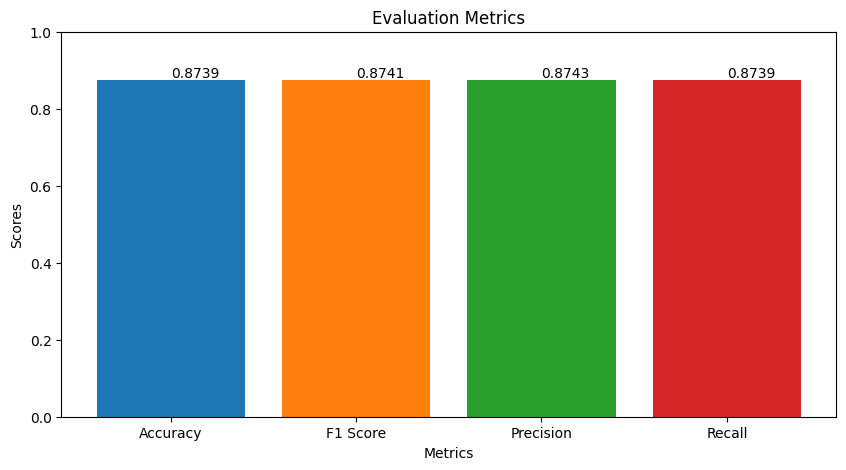

In [11]:
import evaluate
import matplotlib.pyplot as plt

# Initialize the metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

model.eval()

# Evaluate the model on the evaluation dataset
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    # Add batch results to the metrics
    accuracy_metric.add_batch(predictions=predictions, references=batch["labels"])
    f1_metric.add_batch(predictions=predictions, references=batch["labels"])
    precision_metric.add_batch(predictions=predictions, references=batch["labels"])
    recall_metric.add_batch(predictions=predictions, references=batch["labels"])

# Compute the metrics
accuracy = accuracy_metric.compute()['accuracy']
f1 = f1_metric.compute(average='weighted')['f1']
precision = precision_metric.compute(average='weighted')['precision']
recall = recall_metric.compute(average='weighted')['recall']

# Store the metrics in a dictionary for easy plotting
metrics = {
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall
}

# Colors for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # You can customize these colors

# Plot the metrics as a bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(metrics.keys(), metrics.values(), color=colors)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)  # Assuming metrics are between 0 and 1

# Add values on top of the bars for better visualization
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom')  # va: vertical alignment

plt.show()


In [12]:
# Save metrics to a CSV file
metrics_data = {
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Score': [accuracy, f1, precision, recall]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv('/content/drive/MyDrive/metrics_electra.csv', index=False)

In [13]:
import json

# Save the metrics to a file
metrics_filename = '/content/drive/My Drive/metrics_electra.json'  # Change the filename for each model
with open(metrics_filename, 'w') as f:
    json.dump(metrics, f)


In [14]:
import torch

# Save the model to a file
model_path = '/content/drive/My Drive/trained_model_electra.pth'
torch.save(model.state_dict(), model_path)


In [2]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.5 MB/s 

In [6]:
import torch
from transformers import ElectraForSequenceClassification, ElectraTokenizer
import gradio as gr

# Load the model and tokenizer for ELECTRA
model_path = '/content/drive/MyDrive/trained_model_electra.pth'
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=3)  # Adjust num_labels based on your task
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # Use map_location to load on CPU if needed
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')

# Mapping from numerical predictions to original labels
label_map = {0: 'LQ_CLOSE', 1: 'LQ_EDIT', 2: 'HQ'}

def classify_text(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()
    return label_map[predicted_class]

# Create Gradio interface
iface = gr.Interface(
    fn=classify_text,
    inputs=gr.Textbox(lines=2, label="Enter text to classify"),
    outputs=gr.Label(num_top_classes=3),
    title="ELECTRA Text Classification",
    description="Enter text and classify its category using a fine-tuned ELECTRA model."
)

# Launch the interface
iface.launch()


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://a468d9ee45d6e12955.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
